<img src="img/mupiflogo.png" style="float:right;height:80px;">

# Interactive stationary thermo-mechanical workflow 
- Ilustrates how to use model APIs
- Ilustrates the use of data components (Properties and Fields)
- Shows how to combine these concepts and create first workflow

## Problem descrition
 <img src="img/thermomechanicalModa.png" alt="Problem MODA" style="width: 600px;"/>

In [2]:
# local machine only
import sys
sys.path.append('/home/bp/devel/mupif.git')

import matplotlib
# make figures larger
# matplotlib.rcParams['figure.figsize']=(20,20)

# this is ugly
# examples are not part of the mupif module now, thus are copied locally, should be re-considered
sys.path.append('.')
import models

In [3]:
import mupif as mp

 ### Create instances of individual models and get some info about them
 Here we create local instances of both models. To connect to a remote instance a different procedure is needed (and requires the connection information)

In [4]:
thermalSolver = models.ThermalModel()
thermalSolver.getApplicationSignature()

'Stationary thermal-demo-solver, ver 1.0'

In [5]:
mechanicalSolver = models.MechanicalModel()
mechanicalSolver.getApplicationSignature()

'Mechanical-demo-solver, ver 1.0'

### Initialize both model instances, by using *initialize* method, passing required input file  

In [6]:
thermalSolver.initialize('inputT.in')
mechanicalSolver.initialize('inputM.in')

### Explore the input file 

In [7]:
# show the input file
print(open('inputT.in').read())

# Model edges
#     ----------3----------
#     |                   |
#     4                   2
#     |                   | 
#     ----------1---------
#
5 1 #Size x and y
10 5 #Number of elements in x and y
1 N 0. #Domain edge number 1 with boundary condition (D-Dirichlet, C-convection, other-None), prescribed temperature/ambient temperature
2 N 0.
3 N 0.
4 N 0.




### Explore the Inputs/Ouutputs

The model metadata contain many useful information. 
- The model inputs are documented as metadata and can be retrieved using 'Input' key
- The model outputs can be retrieved using 'Output' key

In [8]:
thermalSolver.getMetadata('Inputs')

[{'Name': 'edge temperature',
  'Type': 'mupif.Property',
  'Required': False,
  'Type_ID': 'mupif.PropertyID.PID_Temperature',
  'Obj_ID': ['Cauchy top',
   'Cauchy bottom',
   'Cauchy left',
   'Cauchy right',
   'Dirichlet top',
   'Dirichlet bottom',
   'Dirichlet left',
   'Dirichlet right']}]

In [9]:
thermalSolver.getMetadata('Outputs')

[{'Name': 'temperature',
  'Type_ID': 'mupif.FieldID.FID_Temperature',
  'Type': 'mupif.Field',
  'Required': False}]

### Set some inputs
The model inputs can be set using *set* service. It accepts a supported data type instance (which knows its physical meaning) and optional object_id
- we first create properties to represent boundary conditions
- then use *set* method to apply these to different edges (identified using object_id)

In [10]:
bc1 = mp.ConstantProperty(propID=mp.PropertyID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(50,), unit=mp.U['K'])
bc2 = mp.ConstantProperty(propID=mp.PropertyID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(0,), unit=mp.U['K'])
thermalSolver.set(bc1, 'Cauchy top')
thermalSolver.set(bc2, 'Dirichlet left')
thermalSolver.set(bc2, 'Cauchy bottom')

### Solve the thermal problem
- use *solveStep* method to solve the problem for the given time step

In [11]:
# solve 
thermalSolver.solveStep(mp.TimeStep(time=0,dt=.1,targetTime=1.,unit=mp.U.s))

### Request thermal field
- request the output variables (thermal field in our case) from solver using *get* (or *getField*) method (the fieldID is fieldID=mp.FieldID.FID_Temperature)
- visualize field using *plot2d* method. Fields can be also exprorted to vtk

0.0 5.0 0.0 1.0


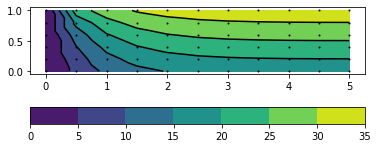

In [12]:
# show the field
f=thermalSolver.getField(fieldID=mp.FieldID.FID_Temperature,time=1.*mp.Q.s)
f.plot2D()

### Map thermal field to mechanical solver
- mapping the thermal field using mechanical model *set* method
- solving (updating) mechanical problem

In [13]:
mechanicalSolver.set(f)
mechanicalSolver.solveStep(mp.TimeStep(time=0,dt=.1,targetTime=1.,unit=mp.U.s))

### Get outputs from mechanical problem
- use getField to request displacement field
- show displacement field (first component is defaul) on deformed configuration

0.0 5.328743957251387 -0.5501256079315806 1.0138262740887825


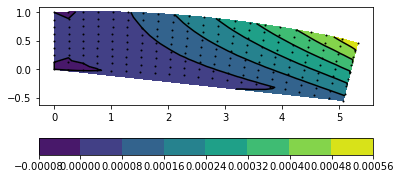

In [14]:
f=mechanicalSolver.getField(fieldID=mp.FieldID.FID_Displacement,time=1.*mp.Q.s)
f.plot2D(warpField=f, warpScale=6.e2)

## Casting into workflow 
The above steps can be formalized into workflow represenation

MuPIF Workflow is represented as a class derived from *Workflow* class
- Workflow class inherits Model interface
- Adds *solve* method to run the whole worklfow
- Similar to models, workflows have to provide their medatadata as well

The example of workflow implementation for this examle is located in <a href="tmworkflow.py">tmworkflow module</a>


In [25]:
import tmworkflow
workflow = tmworkflow.tmworkflow()

In [26]:
# define execution metadata, normally these are provided by scheduler
# but as we execute workflow manually, we neeed to provide these
md = {
    'Execution': {
        'ID': '1',
        'Use_case_ID': '1_1',
        'Task_ID': '1'
    }
}
# initialize workflow
workflow.initialize(metadata=md, targetTime=1.*mp.Q.s)
#set some BCs
bc1 = mp.ConstantProperty(propID=mp.PropertyID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(50,), unit=mp.U['K'])
bc2 = mp.ConstantProperty(propID=mp.PropertyID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(0,), unit=mp.U['K'])
workflow.set(bc1, 'Cauchy top')
workflow.set(bc2, 'Dirichlet left')
workflow.set(bc2, 'Cauchy bottom')
#solve
workflow.solve()

0.0 5.0 0.0 1.0


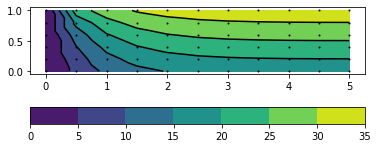

In [27]:
ft=workflow.getField(fieldID=mp.FieldID.FID_Temperature,time=1.*mp.Q.s)
ft.plot2D()

0.0 5.328743957251387 -0.5501256079315806 1.0138262740887825


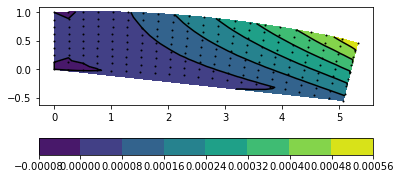

In [28]:
fd=mechanicalSolver.getField(fieldID=mp.FieldID.FID_Displacement,time=1.*mp.Q.s)
fd.plot2D(warpField=fd, warpScale=6.e2)